# Size of SARS-Cov2 virions in class

© 2021 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This notebook is heavily inspired by this [lesson](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/lessons/lesson_05/segmentation.html#Segmentation-by-edge-detection) by Justin Bois.

***

In [18]:
# Always good to have this
import os

# For numerical computation
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc


# For image analysis
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation
import skimage.measure
import scipy.ndimage


# This enables high resolution graphics inline
%config InlineBackend.figure_format = 'retina'
sns.set()

First we need to import the image and load it using `skimage`.

In [3]:
file = "../../data/VeroCells-24hSARS-CoV2_i013.tif"

im = skimage.io.imread(file)

We are going to plot a lot of images in this notebook, so let's write a short function that returns an image given a 2D array.

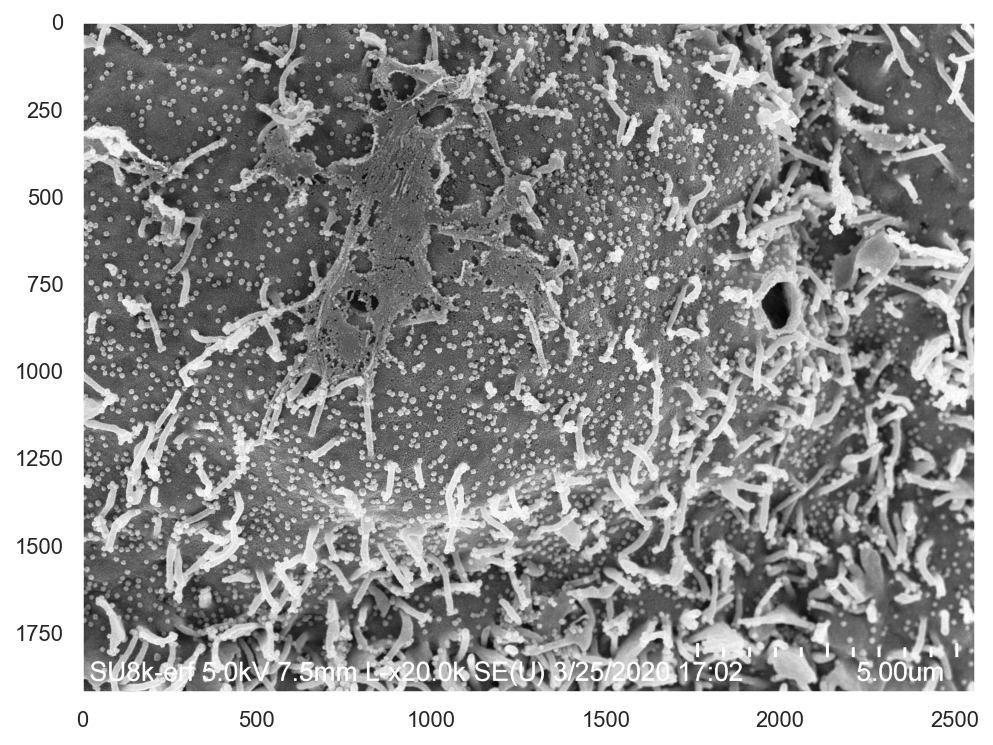

In [4]:
def plot_image(im, cmap=plt.cm.Greys_r, scale=1):
    "Returns a image representation of a 2D array"
    fig, ax = plt.subplots(figsize=(scale*8, scale*8))
    ax.imshow(im, cmap=cmap, aspect=1)
    ax.grid(False)
    return ax

plot_image(im);

For now, let's ignore the scalebar, so we remove that part of the image.

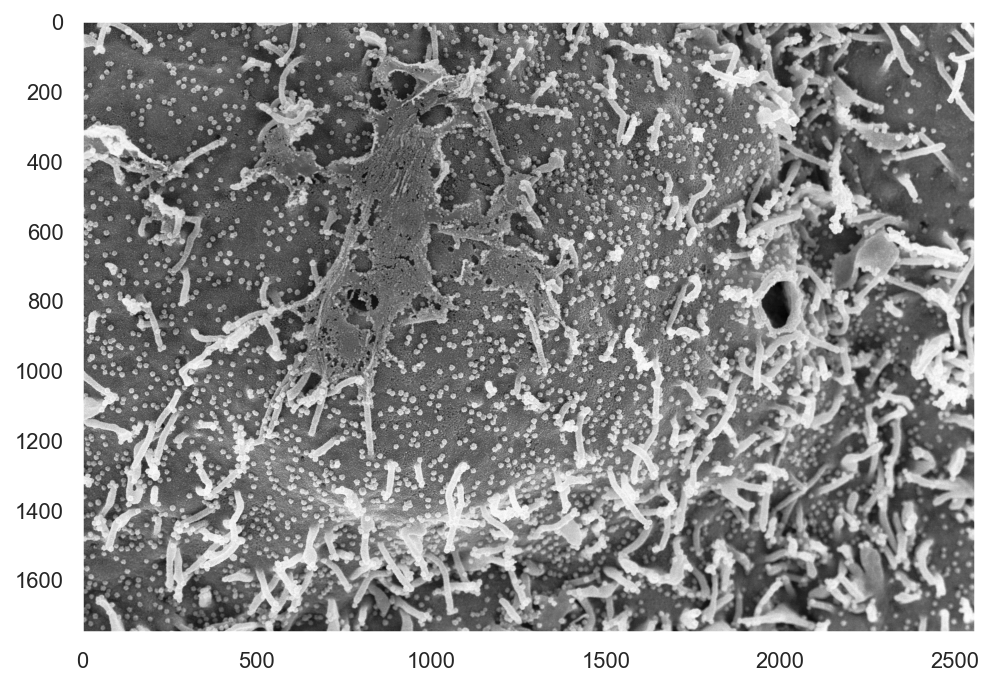

In [5]:
im_c = im[:1750, :]

plot_image(im_c);

The first step is to remove the background. For that purpose, we use a gaussian filter. That means, that each pixel is replaced by an weighted area of its surrounding pixels, where the weights are given by a 2D gaussian distribution. Before we can do that, we have to transform the array of integers into an array of floats.

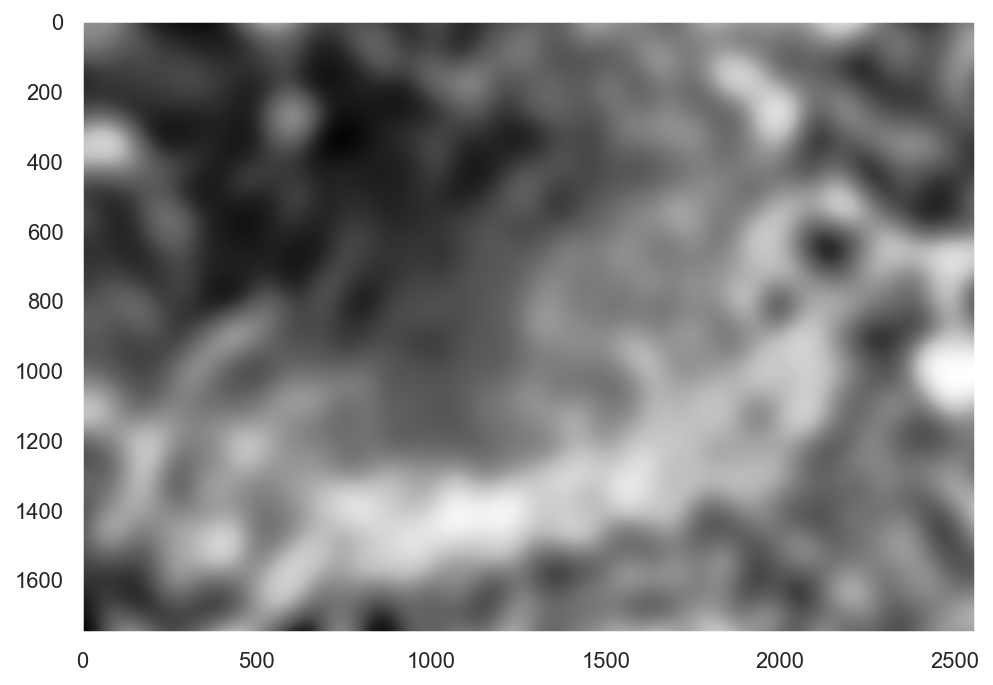

In [6]:
im_float = (im_c - np.min(im_c)) / (np.max(im_c) - np.min(im_c))

im_bg = skimage.filters.gaussian(im_float, 50)
plot_image(im_bg);

Now we can subtract the background from our image and then renormalize the image.

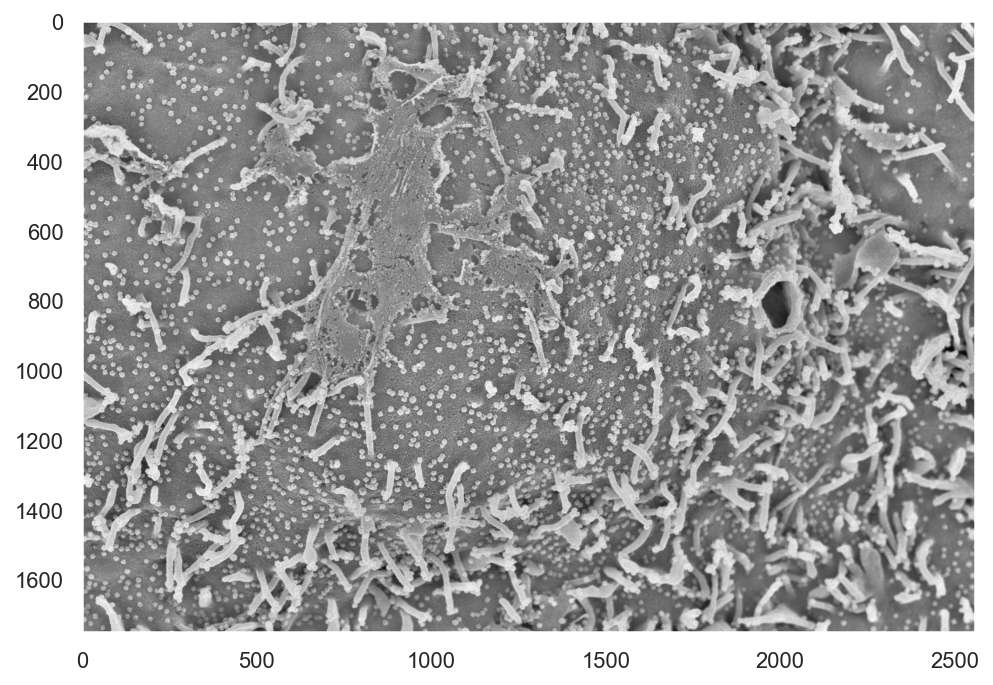

In [7]:
im_float = im_float - im_bg
im_float = (im_float - np.min(im_float)) / (np.max(im_float) - np.min(im_float))

plot_image(im_float);

After background subtraction, we can start identifying particles. To get a better feeling at our progress, we will zoom in a little.

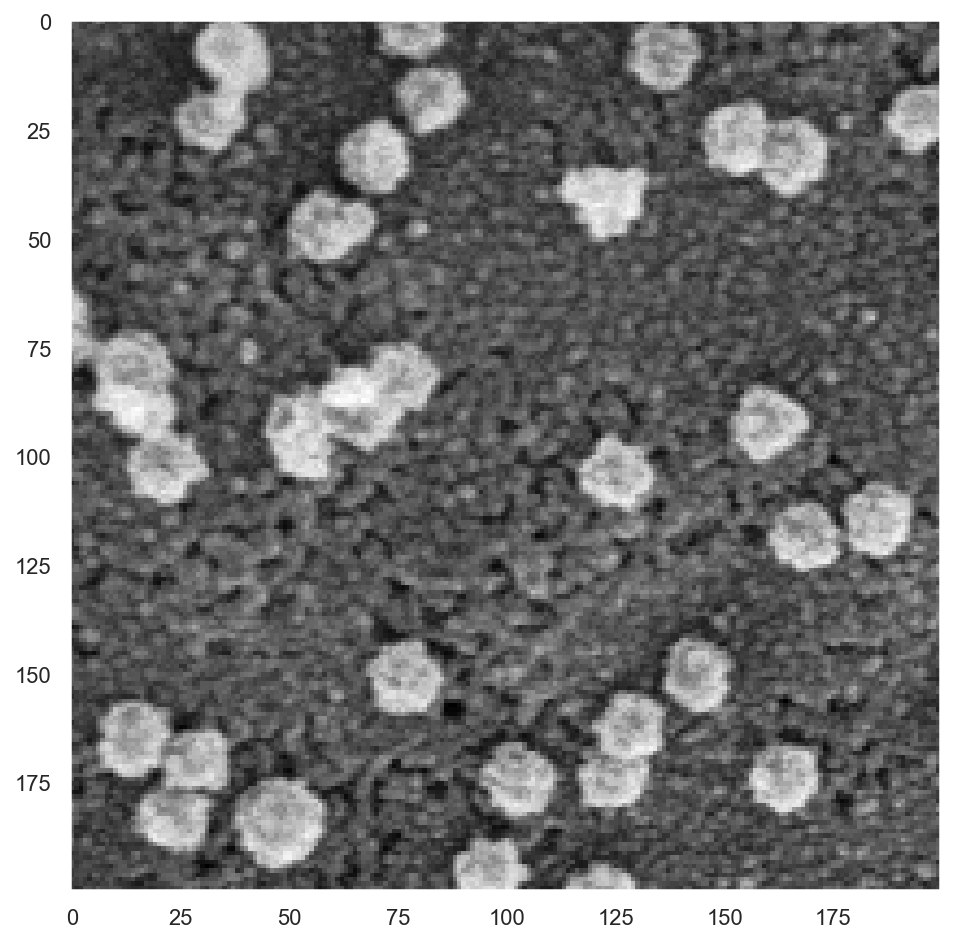

In [8]:
zoom = np.s_[900:1100,900:1100]

plot_image(im_float[zoom]);

There is plenty of "noise" in the background, which might make the next step a little tricky. Therefore, let's apply a gaussian filter with small radius.

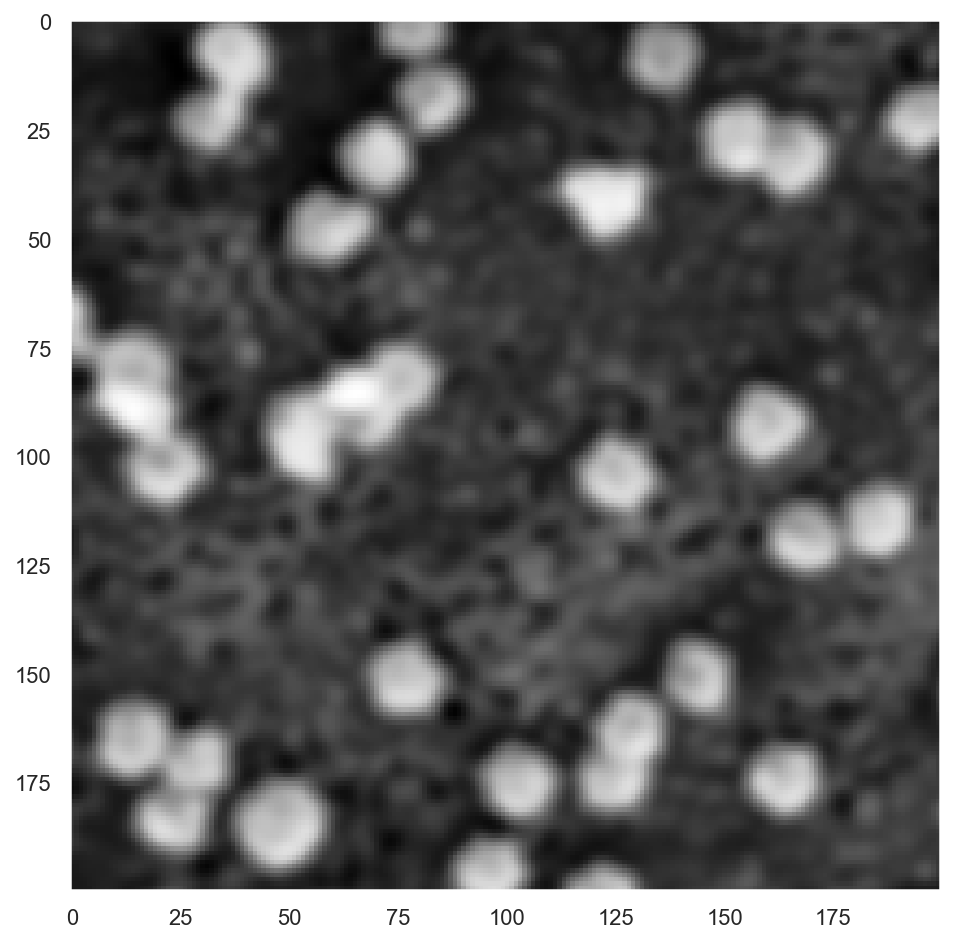

In [11]:
im_filt_gauss = skimage.filters.gaussian(im_float, 2)

plot_image(im_filt_gauss[zoom]);

By eye, we can cleary identify where the virions are. However, we need to be able to tell the computer as well. Therefore, we are performing a step called **thresholding**. Before we can do that, let's look at a histogram of pixel values.

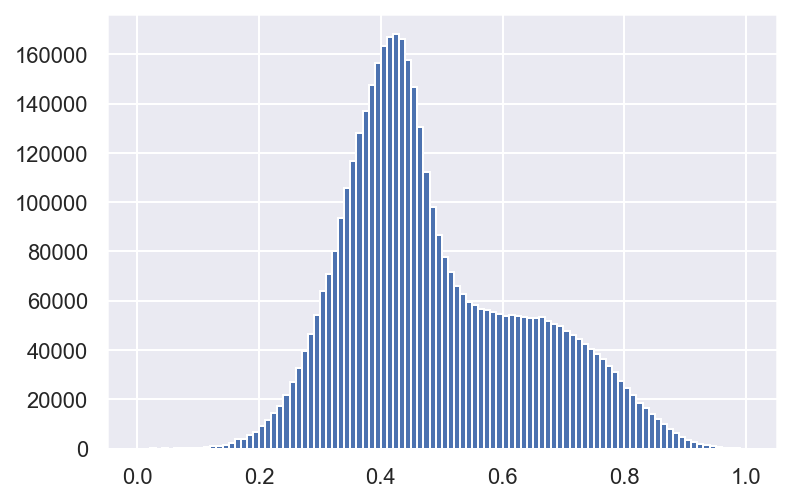

In [13]:
im_norm = (im_filt_gauss - np.min(im_filt_gauss)) / (np.max(im_filt_gauss) - np.min(im_filt_gauss))

plt.hist(im_norm.flatten(), bins=100);

The large peak at lower intensity values is the background. So if we choose a threshold about 0.55, we should be able to get rid of as much background as possible.

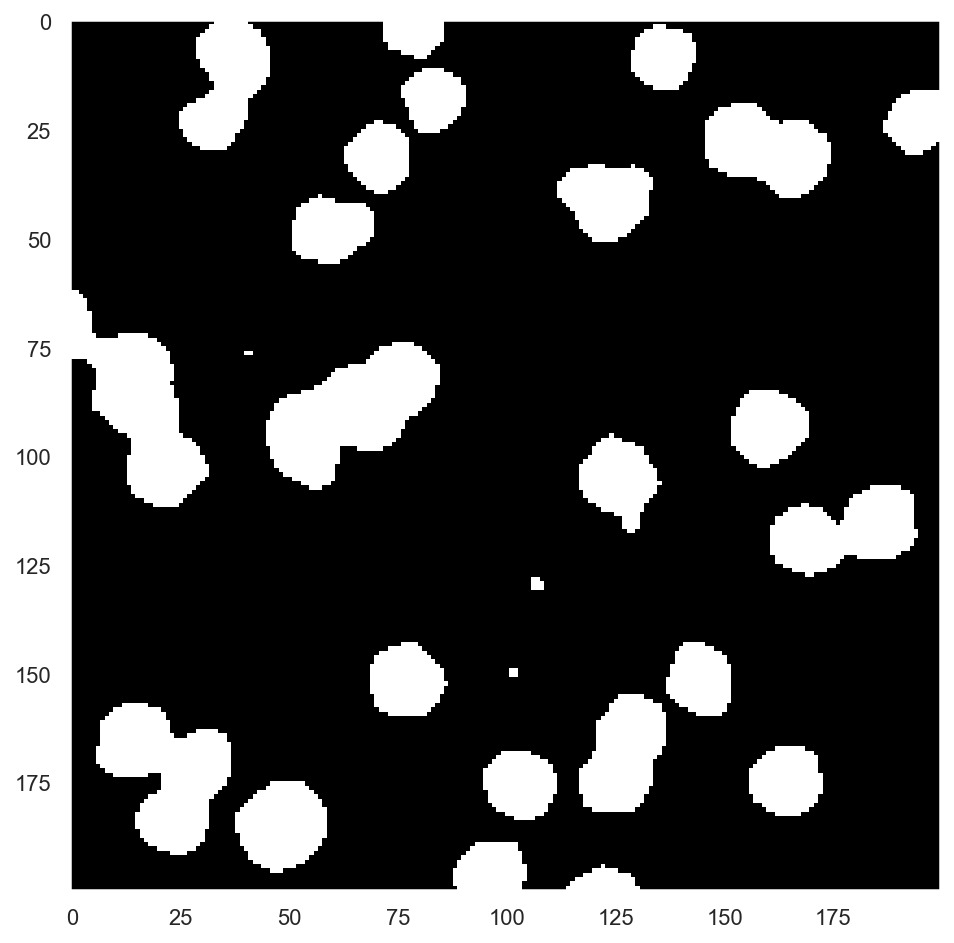

In [15]:
im_thresh = im_norm > 0.55

plot_image(im_thresh[zoom]);

This is already a good starting point. Two main things remain to do here. First, we should get rid of the small background points that are remaining, and second, we should fill the holes that still remain inside the particles. 

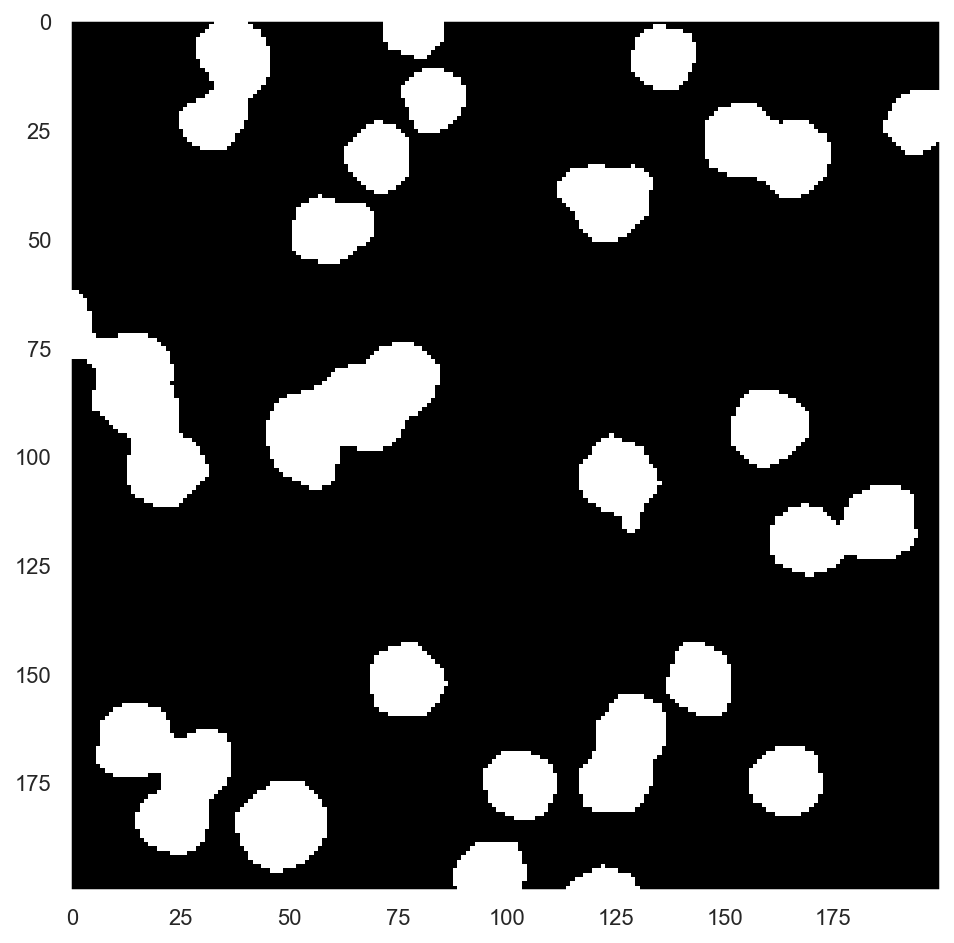

In [40]:
# Remove small objects
im_bw = skimage.morphology.remove_small_objects(im_thresh, min_size=100)

# Fill small holes that have been created by thresholding
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_bw)

# Plot image
plot_image(im_bw[zoom]);

We got some good looking virions in here. There is still a lot of "garbage" in the image, some of which we can remove by clearing the border. This also remomves particles that are cut off at the borders, and would only give a partial area.

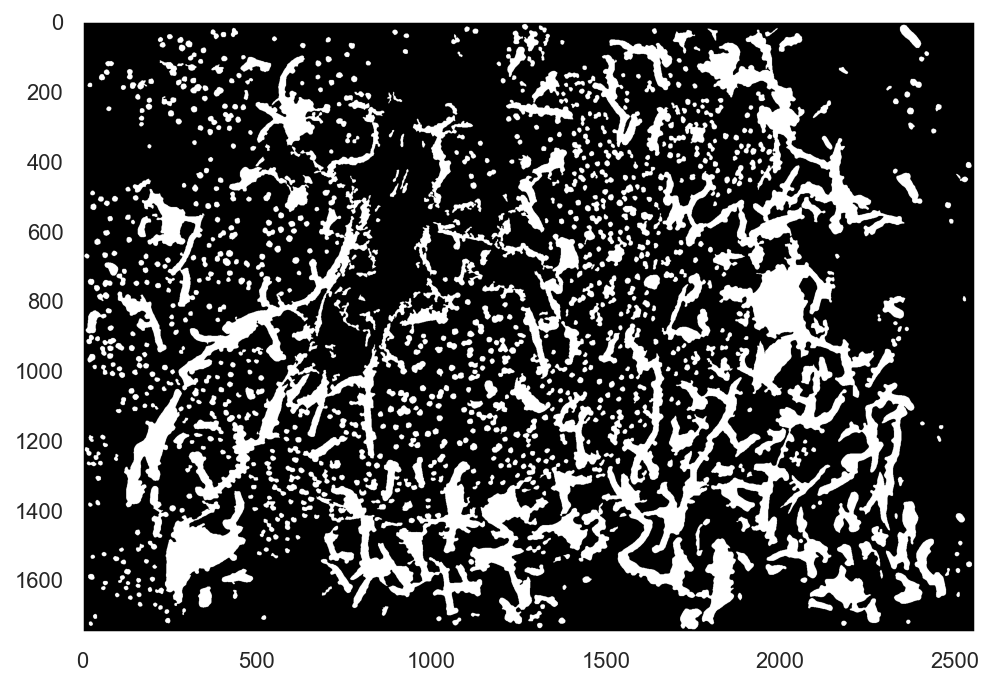

In [20]:
# Clear border with large buffer size b/c LoG procedure came off border
im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)

plot_image(im_bw);

In [21]:
# Find objects and give labels
im_labels, n_labels = skimage.measure.label(im_bw, background=0, return_num=True)

print("Numbers of objects: {}".format(n_labels))

Numbers of objects: 1055


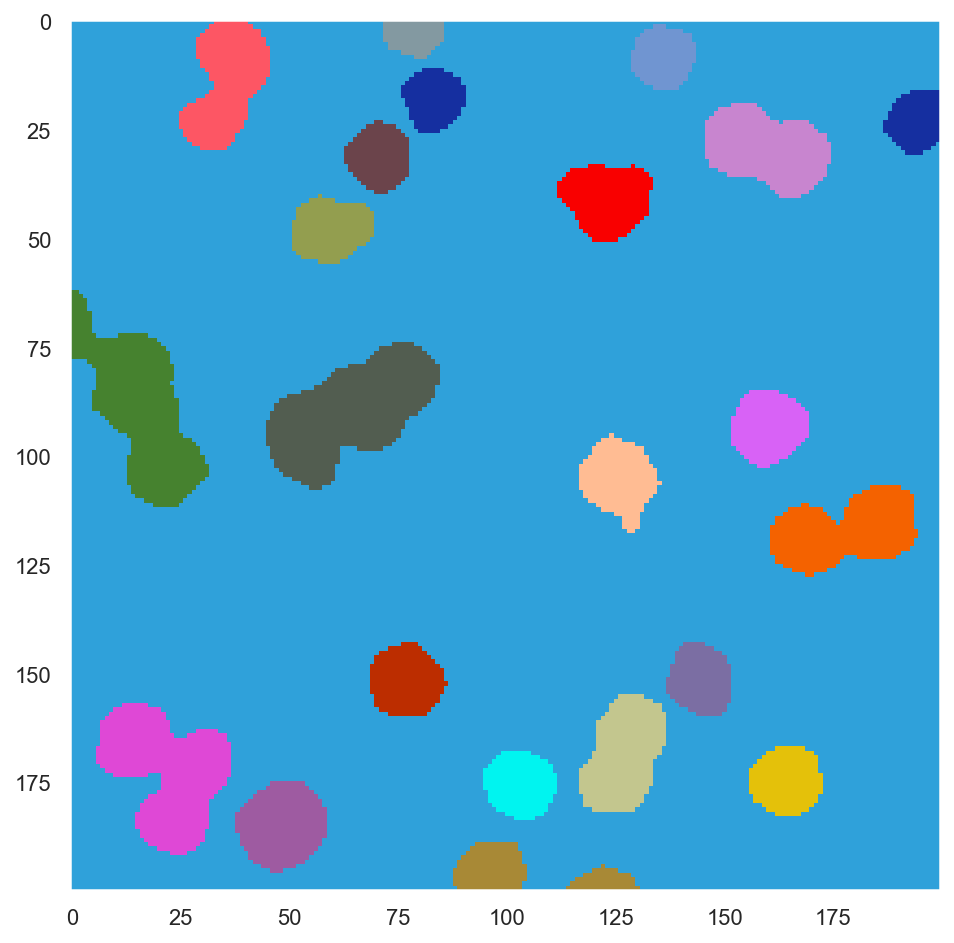

In [41]:
# Plot labeled objects
plot_image(im_labels[zoom], cmap=cc.cm.glasbey_hv);

We did a good job in identifying particels. We have some issues with separating particles that are close together. This can be solved by using other methods of segmentation, which we will not discuss here. Before we can compute the actual particle size, we need to find the size if a pixel.

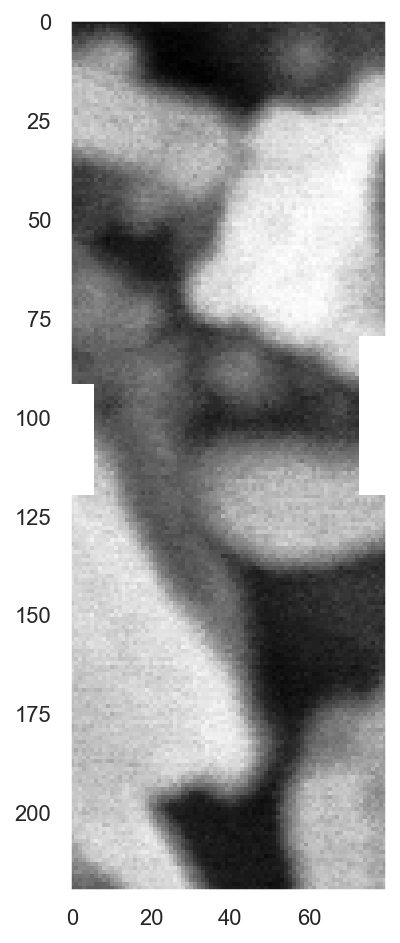

In [43]:
plot_image(im[1700:, 2060:2140]);

Looks like there are 75 pixels between two bars. The space between two bars relates to 500nm, so now we know how large each pixel is. Now we can compute the size of each object. Also, we compute the eccentricity and use that as a filtering criteria.

In [36]:
# Compute object properties
im_props = skimage.measure.regionprops(im_labels)

# Extract interesting properties and store in dataframe
data = [[prop.label, prop.area, prop.eccentricity] for prop in im_props]
df = pd.DataFrame(
    data=data, columns=["label", "area (sq ip distance)", "eccentricity"]
)

# Compute size
df['diameter [nm]'] = np.sqrt(df["area (sq ip distance)"] / np.pi) * 500/75 * 2

# Filter out weirds shapes
df = df.loc[df.eccentricity < 0.4, :]

# Take a look
df

label  area (sq ip distance)  eccentricity  diameter [nm]
10       11                    167      0.355553      97.212483
15       16                    186      0.220785     102.593601
21       22                    140      0.199773      89.007749
29       30                    175      0.391920      99.513689
31       32                    262      0.264847     121.762749
...     ...                    ...           ...            ...
1047   1048                    152      0.383016      92.743951
1050   1051                    173      0.231999      98.943405
1051   1052                    111      0.282762      79.254748
1052   1053                    168      0.367374      97.503104
1054   1055                    178      0.215165     100.363039

[175 rows x 4 columns]

Let's plot a histogram of results!

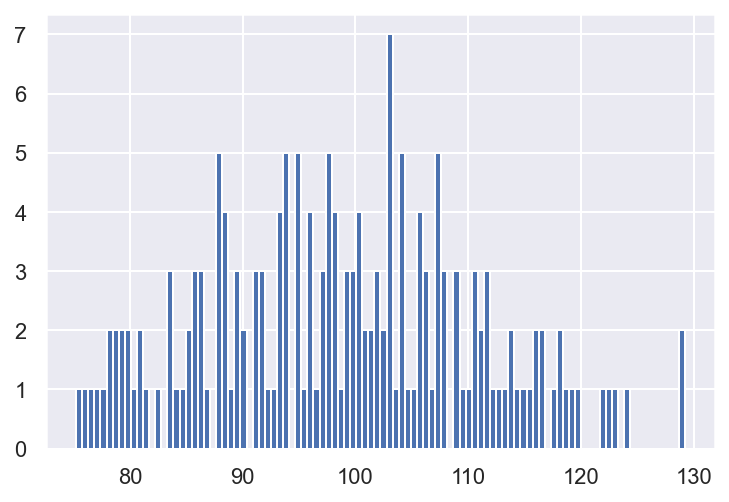

In [37]:
fig, ax = plt.subplots()

ax.hist(df['diameter [nm]'], bins=100);

In [39]:
np.median(df['diameter [nm]'])

98.94340497682572